In [4]:
import torch
from skimage import io, transform
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
from torchvision import datasets
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from livelossplot import PlotLosses
import torch.utils.model_zoo as model_zoo


## Load Images

When loading a set of images in PyTorch we must inherit the Dataset class.

In [3]:
class XRayDataset(Dataset):
    def __init__(self, directory, label, transform=None):
        self.root_dir = directory 
        self.filenames = self.root_loader()
        self.label = label
        self.transform = transform
        
    def root_loader(self):
        if not self.root_dir.endswith('/'):
            self.root_dir = self.root_dir+'/'
        filenames = glob.glob('{}*.jpeg'.format(self.root_dir))
        return filenames 
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self,idx):
        image = io.imread(self.filenames[idx])
        image = image.reshape((image.shape[0], image.shape[1], 1))
        if self.transform:
            image = self.transform(image)
        return image

In [7]:
x_train = XRayDataset('chest_xray/normal/', 'Normal')

## Quick Checks 
We can plot a sampe image from the dataset loader object to just check everything is working properly.

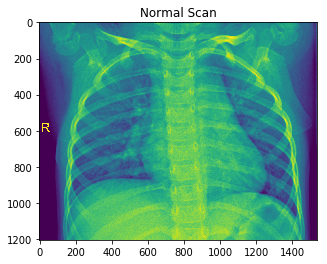

In [8]:
%matplotlib inline
plt.imshow(x_train[0].reshape(x_train[0].shape[0], x_train[0].shape[1]));
plt.title('{} Scan'.format(x_train.label))
plt.show()

## Tensor Conversion
Before we can pass the images through any type of model built in PyTorch we must convert the images to tensors. 

In [9]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = sample.transpose((2, 0, 1))
        return torch.from_numpy(image)

## Check the Conversions are Working

In [10]:
x_train = XRayDataset('chest_xray/normal', 'Normal', transform=transforms.Compose([ToTensor()]))
print('Data now of type: {} \nShape: {}'.format(type(x_train[0]), x_train[0].shape))

Data now of type: <class 'torch.Tensor'> 
Shape: torch.Size([1, 1205, 1538])


## Enable Data Batching
In its current form the data would need to be processed image-by-image using some form of loop. A more efficient way to run this would be through batches which we can enable through the `DataLoader()` object abstraction. Doing this allows for additional efficiencies to be utilised such as multiprocessing.

In [11]:
dataloader = DataLoader(x_train, batch_size=32, shuffle=True)

## Possibly Simpler Method

The images are of differing dimensions so we must resize them to fixed width and height values.

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ]),
}

data_dir = '/home/tpin3694/Documents/university/MSc/thesis/chest_xray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x+'/'),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

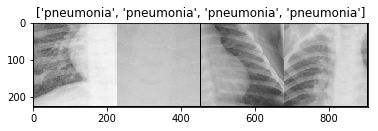

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Defining Our Model

In [7]:
class LeNet_dropout(nn.Module):
    def __init__(self):
        super(LeNet_dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(F.dropout(self.conv1(x), training=True), 2))
        x = F.relu(F.max_pool2d(F.dropout(self.conv2(x), training=True), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=True)
        x = self.fc2(x)
        return x
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(F.dropout(self.conv1(x), training=True)))
        x = self.pool(F.relu(F.dropout(self.conv2(x), training=True)))
        x = x.view(-1, 16*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

## Instatiate Model


In [9]:
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        print('Loading Pre-Trained Weights')
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    print('Model Created')
    return model

## Training Our Model

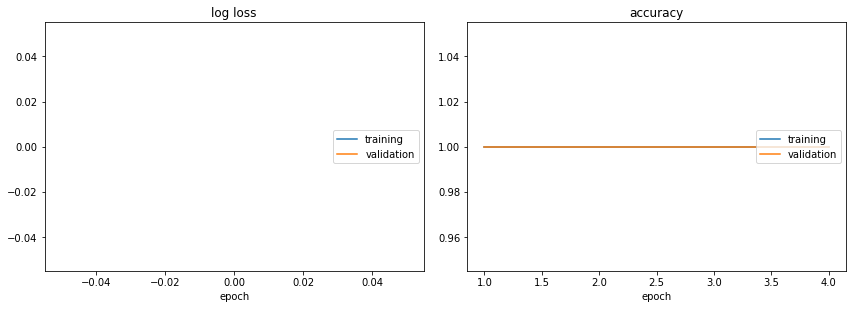

Train Epoch: 4 [0/1171 (0%)] lr: 0.01	Loss: nan
Train Epoch: 4 [40/1171 (1%)] lr: 0.01	Loss: nan
Train Epoch: 4 [80/1171 (2%)] lr: 0.01	Loss: nan
Train Epoch: 4 [120/1171 (3%)] lr: 0.01	Loss: nan
Train Epoch: 4 [160/1171 (3%)] lr: 0.01	Loss: nan
Train Epoch: 4 [200/1171 (4%)] lr: 0.01	Loss: nan
Train Epoch: 4 [240/1171 (5%)] lr: 0.01	Loss: nan
Train Epoch: 4 [280/1171 (6%)] lr: 0.01	Loss: nan
Train Epoch: 4 [320/1171 (7%)] lr: 0.01	Loss: nan
Train Epoch: 4 [360/1171 (8%)] lr: 0.01	Loss: nan
Train Epoch: 4 [400/1171 (9%)] lr: 0.01	Loss: nan
Train Epoch: 4 [440/1171 (9%)] lr: 0.01	Loss: nan
Train Epoch: 4 [480/1171 (10%)] lr: 0.01	Loss: nan
Train Epoch: 4 [520/1171 (11%)] lr: 0.01	Loss: nan
Train Epoch: 4 [560/1171 (12%)] lr: 0.01	Loss: nan
Train Epoch: 4 [600/1171 (13%)] lr: 0.01	Loss: nan
Train Epoch: 4 [640/1171 (14%)] lr: 0.01	Loss: nan
Train Epoch: 4 [680/1171 (15%)] lr: 0.01	Loss: nan
Train Epoch: 4 [720/1171 (15%)] lr: 0.01	Loss: nan
Train Epoch: 4 [760/1171 (16%)] lr: 0.01	Loss: 

In [ ]:
lr=0.01
momentum=0.5
epochs=5

model = alexnet(True)
optimiser = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

def train(model, optimiser, lr, current_epoch):
    # Setup plotting values
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_loss_val = 0.0
    epoch_correct_val = 0
    lr = lr * (0.1 ** (current_epoch // 10))
    optimiser.param_groups[0]['lr'] = lr
    
    for batch_idx, (data, target) in enumerate(dataloaders['train']):
        if device.type!='cpu':
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimiser.zero_grad()
        output = model(data)
        loss = F.nll_loss(F.log_softmax(output), target)
        loss.backward()
        optimiser.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] lr: {}\tLoss: {:.6f}'
                  .format(current_epoch, batch_idx * len(data), len(dataloaders['train']), 100. * batch_idx / len(dataloaders['train']), lr, loss.data[0]))
        epoch_loss += loss.data[0]
        epoch_correct += (output.max(1)[1] == target).sum().data[0]

    avg_loss = epoch_loss / len(dataloaders['train'])
    avg_accuracy = epoch_correct / len(dataloaders['train'])
    
    for batch_idx, (data, target) in enumerate(dataloaders['test']):
        data, target = Variable(data), Variable(target)
        ouput = model(data)
        
        loss = F.nll_loss(F.log_softmax(output), target)
        
        
        epoch_loss_val += loss.data[0]
        epoch_correct_val += (output.max(1)[1] == target).sum().data[0]
        
    avg_loss_val = epoch_loss_val / len(dataloaders['test'])
    avg_accuracy_val = epoch_correct_val / len(dataloaders['test'])
    
    liveloss.update({
        'log loss': avg_loss,
        'val_log loss': avg_loss_val,
        'accuracy': avg_accuracy,
        'val_accuracy': avg_accuracy_val
    })
    liveloss.draw()


liveloss = PlotLosses()
for i in range(epochs):    
    # Train
    train(model, optimiser, lr, i)
